<a href="https://colab.research.google.com/github/chebil/stat/blob/main/part3/ch09_conjugate.ipynb" target="_blank" rel="noopener noreferrer"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 9.3 Conjugate Priors and MAP Estimation

## Conjugate Priors

### Definition

A prior distribution is **conjugate** to a likelihood if the posterior has the **same distributional form** as the prior.

$$
\text{Prior family} + \text{Likelihood} \Rightarrow \text{Posterior in same family}
$$

**Why Conjugacy Matters**:
- Closed-form posterior (no numerical integration needed)
- Easy sequential updating
- Interpretable hyperparameters
- Computational efficiency

## Common Conjugate Pairs

### Table of Conjugate Priors

| Likelihood | Parameter | Conjugate Prior | Posterior |
|------------|-----------|-----------------|------------|
| Bernoulli(p) | p | Beta(α, β) | Beta(α+k, β+n-k) |
| Binomial(n, p) | p | Beta(α, β) | Beta(α+k, β+n-k) |
| Poisson(λ) | λ | Gamma(α, β) | Gamma(α+Σx, β+n) |
| Exponential(λ) | λ | Gamma(α, β) | Gamma(α+n, β+Σx) |
| Normal(μ, σ²) | μ (σ² known) | Normal(μ₀, σ₀²) | Normal(...) |
| Normal(μ, σ²) | σ² (μ known) | Inverse-Gamma | Inverse-Gamma |

where:
- k = number of successes
- n = number of trials
- Σx = sum of observations

## Beta-Binomial (Detailed)

### The Setup

**Likelihood**: Binomial

$$
p(k \mid p, n) = \binom{n}{k} p^k (1-p)^{n-k}
$$

**Prior**: Beta

$$
p(p) = \frac{\Gamma(\alpha + \beta)}{\Gamma(\alpha)\Gamma(\beta)} p^{\alpha-1}(1-p)^{\beta-1}
$$

### Posterior Derivation

$$
p(p \mid k, n) \propto p(k \mid p) \cdot p(p)
$$

$$
\propto p^k (1-p)^{n-k} \cdot p^{\alpha-1}(1-p)^{\beta-1}
$$

$$
= p^{(\alpha+k)-1}(1-p)^{(\beta+n-k)-1}
$$

This is the kernel of:

$$
p(p \mid k, n) = \text{Beta}(\alpha + k, \beta + n - k)
$$

### Hyperparameter Interpretation

**Prior hyperparameters**:
- \(\alpha\) = "pseudo-counts" of successes
- \(\beta\) = "pseudo-counts" of failures
- \(\alpha + \beta\) = "effective sample size" of prior

**Prior mean**: \(\frac{\alpha}{\alpha + \beta}\)

**Posterior mean**:

$$
\frac{\alpha + k}{\alpha + \beta + n} = \frac{\alpha + \beta}{\alpha + \beta + n} \cdot \frac{\alpha}{\alpha + \beta} + \frac{n}{\alpha + \beta + n} \cdot \frac{k}{n}
$$

This is a **weighted average** of prior mean and MLE!

### Python Implementation

Beta-Binomial Conjugacy Example

Prior: Beta(2, 2)
Prior mean: 0.500

Data: 15 successes in 20 trials
MLE: 0.750

Posterior: Beta(17, 7)
Posterior mean: 0.708


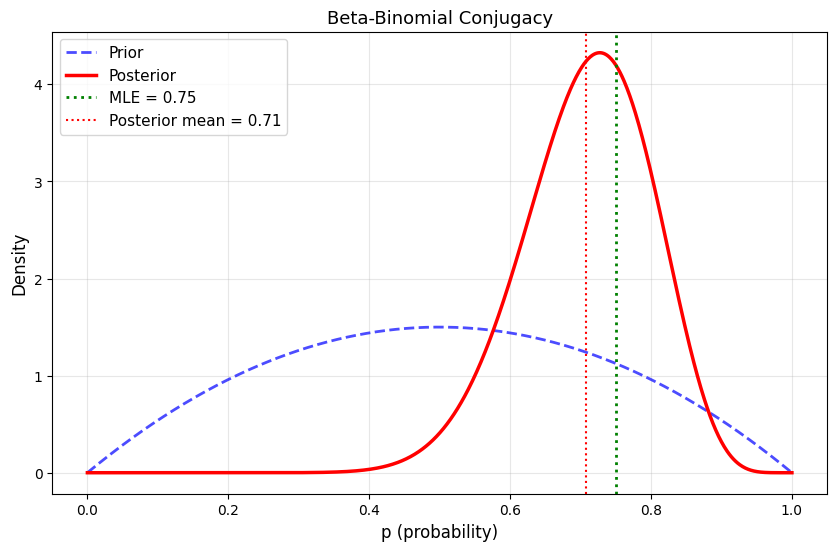

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

def beta_binomial_update(alpha_prior, beta_prior, k, n):
    """
    Update Beta prior with Binomial data.
    
    Parameters:
    -----------
    alpha_prior, beta_prior : Prior Beta parameters
    k : Number of successes observed
    n : Number of trials
    
    Returns:
    --------
    alpha_post, beta_post : Posterior Beta parameters
    """
    alpha_post = alpha_prior + k
    beta_post = beta_prior + (n - k)
    return alpha_post, beta_post

# Example
print("Beta-Binomial Conjugacy Example")
print("="*70)

# Prior
alpha_prior, beta_prior = 2, 2
print(f"\nPrior: Beta({alpha_prior}, {beta_prior})")
print(f"Prior mean: {alpha_prior/(alpha_prior + beta_prior):.3f}")

# Data
k, n = 15, 20  # 15 successes in 20 trials
print(f"\nData: {k} successes in {n} trials")
print(f"MLE: {k/n:.3f}")

# Posterior
alpha_post, beta_post = beta_binomial_update(alpha_prior, beta_prior, k, n)
print(f"\nPosterior: Beta({alpha_post}, {beta_post})")
print(f"Posterior mean: {alpha_post/(alpha_post + beta_post):.3f}")

# Visualize
p_range = np.linspace(0, 1, 1000)
prior = stats.beta(alpha_prior, beta_prior)
posterior = stats.beta(alpha_post, beta_post)

plt.figure(figsize=(10, 6))
plt.plot(p_range, prior.pdf(p_range), 'b--', linewidth=2, label='Prior', alpha=0.7)
plt.plot(p_range, posterior.pdf(p_range), 'r-', linewidth=2.5, label='Posterior')
plt.axvline(k/n, color='green', linestyle=':', linewidth=2, label=f'MLE = {k/n:.2f}')
plt.axvline(alpha_post/(alpha_post + beta_post), color='red', linestyle=':', 
            linewidth=1.5, label=f'Posterior mean = {alpha_post/(alpha_post + beta_post):.2f}')
plt.xlabel('p (probability)', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.title('Beta-Binomial Conjugacy', fontsize=13)
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.savefig('beta_binomial_conjugate.png', dpi=150, bbox_inches='tight')
plt.show()

## Gamma-Poisson (Detailed)

### The Setup

**Likelihood**: Poisson observations \(x_1, \ldots, x_n\)

$$
p(x_1, \ldots, x_n \mid \lambda) = \prod_{i=1}^{n} \frac{\lambda^{x_i} e^{-\lambda}}{x_i!} \propto \lambda^{\sum x_i} e^{-n\lambda}
$$

**Prior**: Gamma

$$
p(\lambda) = \text{Gamma}(\alpha, \beta) = \frac{\beta^\alpha}{\Gamma(\alpha)} \lambda^{\alpha-1} e^{-\beta \lambda}
$$

### Posterior Derivation

$$
p(\lambda \mid x_1, \ldots, x_n) \propto p(x_1, \ldots, x_n \mid \lambda) \cdot p(\lambda)
$$

$$
\propto \lambda^{\sum x_i} e^{-n\lambda} \cdot \lambda^{\alpha-1} e^{-\beta \lambda}
$$

$$
= \lambda^{(\alpha + \sum x_i) - 1} e^{-(\beta + n)\lambda}
$$

This is the kernel of:

$$
p(\lambda \mid x_1, \ldots, x_n) = \text{Gamma}(\alpha + \sum x_i, \beta + n)
$$

### Hyperparameter Interpretation

- \(\alpha\) = prior "total count"
- \(\beta\) = prior "observation periods"
- Prior mean: \(\frac{\alpha}{\beta}\)
- Posterior mean: \(\frac{\alpha + \sum x_i}{\beta + n}\)

### Python Implementation

Gamma-Poisson Conjugacy Example

True λ: 5.0
Data: 30 observations, sum = 142
MLE: 4.733

Prior: Gamma(2, 1)
Prior mean: 2.000

Posterior: Gamma(144, 31)
Posterior mean: 4.645


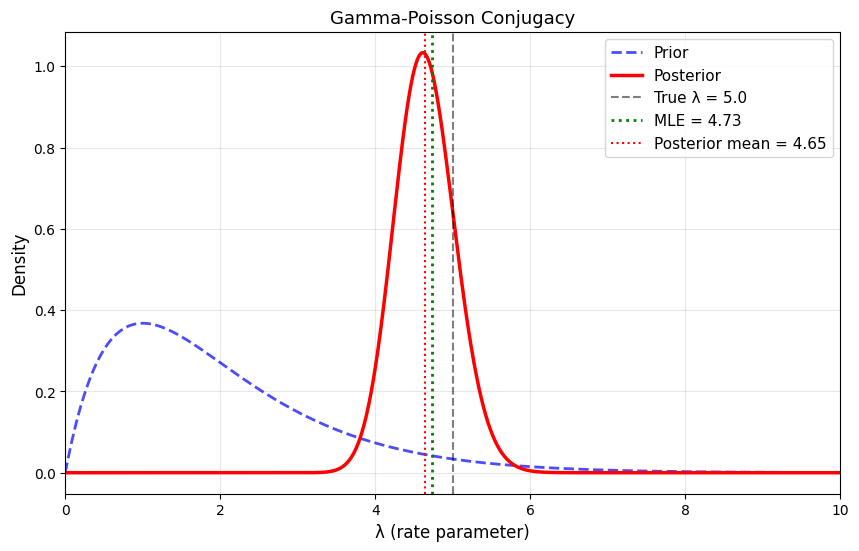

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

np.random.seed(42)

# True parameter
true_lambda = 5.0

# Generate Poisson data
n = 30
data = np.random.poisson(true_lambda, n)
sum_x = np.sum(data)

print("Gamma-Poisson Conjugacy Example")
print("="*70)
print(f"\nTrue λ: {true_lambda}")
print(f"Data: {n} observations, sum = {sum_x}")
print(f"MLE: {sum_x/n:.3f}")

# Prior: Gamma(2, 1) - weakly informative
alpha_prior = 2
beta_prior = 1
print(f"\nPrior: Gamma({alpha_prior}, {beta_prior})")
print(f"Prior mean: {alpha_prior/beta_prior:.3f}")

# Posterior
alpha_post = alpha_prior + sum_x
beta_post = beta_prior + n
print(f"\nPosterior: Gamma({alpha_post}, {beta_post})")
print(f"Posterior mean: {alpha_post/beta_post:.3f}")

# Visualize
lambda_range = np.linspace(0, 10, 1000)
prior = stats.gamma(alpha_prior, scale=1/beta_prior)
posterior = stats.gamma(alpha_post, scale=1/beta_post)

plt.figure(figsize=(10, 6))
plt.plot(lambda_range, prior.pdf(lambda_range), 'b--', linewidth=2, 
         label='Prior', alpha=0.7)
plt.plot(lambda_range, posterior.pdf(lambda_range), 'r-', linewidth=2.5, 
         label='Posterior')
plt.axvline(true_lambda, color='black', linestyle='--', linewidth=1.5,
            label=f'True λ = {true_lambda}', alpha=0.5)
plt.axvline(sum_x/n, color='green', linestyle=':', linewidth=2,
            label=f'MLE = {sum_x/n:.2f}')
plt.axvline(alpha_post/beta_post, color='red', linestyle=':', linewidth=1.5,
            label=f'Posterior mean = {alpha_post/beta_post:.2f}')
plt.xlabel('λ (rate parameter)', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.title('Gamma-Poisson Conjugacy', fontsize=13)
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.xlim(0, 10)
plt.savefig('gamma_poisson_conjugate.png', dpi=150, bbox_inches='tight')
plt.show()

## Normal-Normal (Known Variance)

### The Setup

**Likelihood**: \(x_1, \ldots, x_n \sim N(\mu, \sigma^2)\) where \(\sigma^2\) is known

$$
p(x_1, \ldots, x_n \mid \mu) \propto \exp\left(-\frac{1}{2\sigma^2}\sum_{i=1}^{n}(x_i - \mu)^2\right)
$$

**Prior**: \(\mu \sim N(\mu_0, \sigma_0^2)\)

$$
p(\mu) \propto \exp\left(-\frac{(\mu - \mu_0)^2}{2\sigma_0^2}\right)
$$

### Posterior (Closed Form)

The posterior is also Normal:

$$
p(\mu \mid x_1, \ldots, x_n) = N(\mu_n, \sigma_n^2)
$$

where:

**Posterior mean**:

$$
\mu_n = \frac{\sigma^2}{\sigma^2 + n\sigma_0^2} \mu_0 + \frac{n\sigma_0^2}{\sigma^2 + n\sigma_0^2} \bar{x}
$$

**Posterior variance**:

$$
\frac{1}{\sigma_n^2} = \frac{1}{\sigma_0^2} + \frac{n}{\sigma^2}
$$

(Precision of posterior = precision of prior + precision of data)

### Interpretation

- Posterior mean is weighted average of prior mean and sample mean
- Weights depend on relative precisions (inverse variances)
- As \(n \to \infty\), posterior mean \(\to \bar{x}\) (data dominates)
- Posterior variance always smaller than prior variance (we learned!)

### Python Implementation

Normal-Normal Conjugacy Example

True μ: 5.0
Known σ: 2.0
Data: n = 10, x̄ = 5.896
MLE: 5.896

Prior: N(0.0, 25.0)

Posterior: N(5.803, 0.394)
Posterior mean: 5.803
Posterior std: 0.627


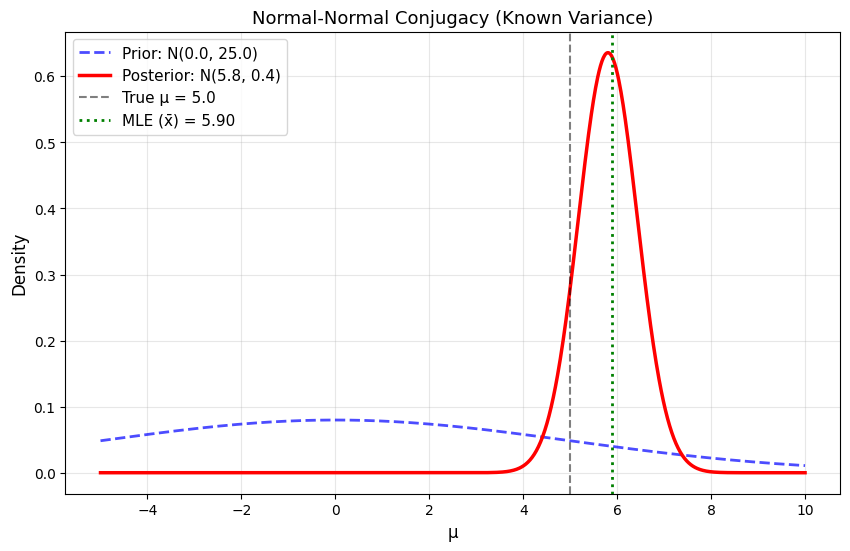

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

np.random.seed(42)

# True parameter
true_mu = 5.0
sigma = 2.0  # Known variance

# Generate data
n = 10
data = np.random.normal(true_mu, sigma, n)
xbar = np.mean(data)

print("Normal-Normal Conjugacy Example")
print("="*70)
print(f"\nTrue μ: {true_mu}")
print(f"Known σ: {sigma}")
print(f"Data: n = {n}, x̄ = {xbar:.3f}")
print(f"MLE: {xbar:.3f}")

# Prior
mu_0 = 0.0
sigma_0 = 5.0
print(f"\nPrior: N({mu_0}, {sigma_0**2})")

# Posterior parameters
precision_prior = 1 / sigma_0**2
precision_data = n / sigma**2
precision_post = precision_prior + precision_data
sigma_n = np.sqrt(1 / precision_post)

mu_n = (precision_prior * mu_0 + precision_data * xbar) / precision_post

print(f"\nPosterior: N({mu_n:.3f}, {sigma_n**2:.3f})")
print(f"Posterior mean: {mu_n:.3f}")
print(f"Posterior std: {sigma_n:.3f}")

# Visualize
mu_range = np.linspace(-5, 10, 1000)
prior = stats.norm(mu_0, sigma_0)
posterior = stats.norm(mu_n, sigma_n)

plt.figure(figsize=(10, 6))
plt.plot(mu_range, prior.pdf(mu_range), 'b--', linewidth=2, 
         label=f'Prior: N({mu_0}, {sigma_0**2})', alpha=0.7)
plt.plot(mu_range, posterior.pdf(mu_range), 'r-', linewidth=2.5,
         label=f'Posterior: N({mu_n:.1f}, {sigma_n**2:.1f})')
plt.axvline(true_mu, color='black', linestyle='--', linewidth=1.5,
            label=f'True μ = {true_mu}', alpha=0.5)
plt.axvline(xbar, color='green', linestyle=':', linewidth=2,
            label=f'MLE (x̄) = {xbar:.2f}')
plt.xlabel('μ', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.title('Normal-Normal Conjugacy (Known Variance)', fontsize=13)
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.savefig('normal_normal_conjugate.png', dpi=150, bbox_inches='tight')
plt.show()

## Maximum A Posteriori (MAP) Estimation

### Definition

The **MAP estimate** is the mode of the posterior distribution:

$$
\hat{\theta}_{\text{MAP}} = \arg\max_{\theta} p(\theta \mid \text{data})
$$

Expanding:

$$
\hat{\theta}_{\text{MAP}} = \arg\max_{\theta} p(\text{data} \mid \theta) \cdot p(\theta)
$$

Taking logs:

$$
\hat{\theta}_{\text{MAP}} = \arg\max_{\theta} \left[ \log p(\text{data} \mid \theta) + \log p(\theta) \right]
$$

### MAP vs. MLE

**MLE**:

$$
\hat{\theta}_{\text{MLE}} = \arg\max_{\theta} \log p(\text{data} \mid \theta)
$$

**MAP**:

$$
\hat{\theta}_{\text{MAP}} = \arg\max_{\theta} \left[ \log p(\text{data} \mid \theta) + \log p(\theta) \right]
$$

**Key insight**: MAP = MLE + log prior penalty

### MAP as Regularized MLE

The log prior acts as a **regularization term**!

**Example**: Normal prior \(\theta \sim N(0, \sigma_p^2)\)

$$
\log p(\theta) = -\frac{\theta^2}{2\sigma_p^2} + \text{const}
$$

So MAP becomes:

$$
\hat{\theta}_{\text{MAP}} = \arg\max_{\theta} \left[ \log p(\text{data} \mid \theta) - \frac{\theta^2}{2\sigma_p^2} \right]
$$

This is equivalent to **L2 regularization (Ridge regression)**!

### When MAP = Posterior Mean

For **symmetric unimodal** posteriors:
- Mode = Mean = Median
- MAP estimate = Posterior mean

Examples: Normal posterior, symmetric Beta

### Python Example: Comparing Point Estimates

Comparing Point Estimates: MLE, MAP, Posterior Mean

Data: 15 heads in 20 flips
True p: 0.7

Prior: Beta(2, 2)
Posterior: Beta(17, 7)

Point Estimates:
  MLE (no prior):      0.7500
  MAP (mode):          0.7273
  Posterior mean:      0.7083
  Posterior median:    0.7142
  True p:              0.7000


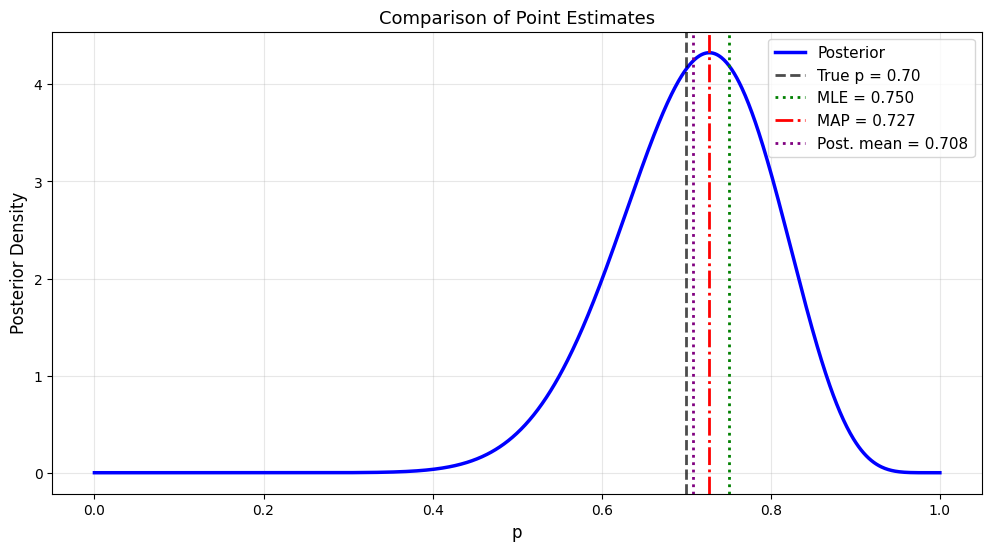

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.optimize import minimize_scalar

np.random.seed(42)

# Data
true_p = 0.7
n = 20
k = np.random.binomial(n, true_p)

print("Comparing Point Estimates: MLE, MAP, Posterior Mean")
print("="*70)
print(f"\nData: {k} heads in {n} flips")
print(f"True p: {true_p}")

# Prior: Beta(2, 2)
alpha_prior, beta_prior = 2, 2

# Posterior: Beta(alpha + k, beta + n - k)
alpha_post = alpha_prior + k
beta_post = beta_prior + (n - k)

print(f"\nPrior: Beta({alpha_prior}, {beta_prior})")
print(f"Posterior: Beta({alpha_post}, {beta_post})")

# Point estimates
p_mle = k / n
p_map = (alpha_post - 1) / (alpha_post + beta_post - 2)  # Mode of Beta
p_mean = alpha_post / (alpha_post + beta_post)  # Mean of Beta
p_median = stats.beta(alpha_post, beta_post).median()

print(f"\nPoint Estimates:")
print(f"  MLE (no prior):      {p_mle:.4f}")
print(f"  MAP (mode):          {p_map:.4f}")
print(f"  Posterior mean:      {p_mean:.4f}")
print(f"  Posterior median:    {p_median:.4f}")
print(f"  True p:              {true_p:.4f}")

# Visualize
p_range = np.linspace(0, 1, 1000)
posterior = stats.beta(alpha_post, beta_post)

plt.figure(figsize=(12, 6))
plt.plot(p_range, posterior.pdf(p_range), 'b-', linewidth=2.5, 
         label='Posterior')
plt.axvline(true_p, color='black', linestyle='--', linewidth=2,
            label=f'True p = {true_p:.2f}', alpha=0.7)
plt.axvline(p_mle, color='green', linestyle=':', linewidth=2,
            label=f'MLE = {p_mle:.3f}')
plt.axvline(p_map, color='red', linestyle='-.', linewidth=2,
            label=f'MAP = {p_map:.3f}')
plt.axvline(p_mean, color='purple', linestyle=':', linewidth=2,
            label=f'Post. mean = {p_mean:.3f}')
plt.xlabel('p', fontsize=12)
plt.ylabel('Posterior Density', fontsize=12)
plt.title('Comparison of Point Estimates', fontsize=13)
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.savefig('point_estimates_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

## Summary

### Conjugate Priors

| Distribution | Conjugate Prior | Update Rule |
|--------------|-----------------|-------------|
| Bernoulli/Binomial | Beta(α, β) | α → α+k, β → β+n-k |
| Poisson | Gamma(α, β) | α → α+Σx, β → β+n |
| Normal (μ unknown) | Normal(μ₀, σ₀²) | Precision adds |

### Point Estimates

**MLE**: \(\arg\max p(\text{data} \mid \theta)\)

**MAP**: \(\arg\max p(\theta \mid \text{data})\) = MLE + prior penalty

**Posterior Mean**: \(\mathbb{E}[\theta \mid \text{data}]\) = Optimal under squared loss

### Key Insights

✅ Conjugacy → closed-form posteriors
✅ MAP = regularized MLE
✅ Hyperparameters = "pseudo-data"
✅ As n → ∞, all estimates converge
✅ Prior matters most with small data